In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math
import skimage.transform as sktr

libpng warning: iCCP: profile 'icc': 0h: PCS illuminant is not D50


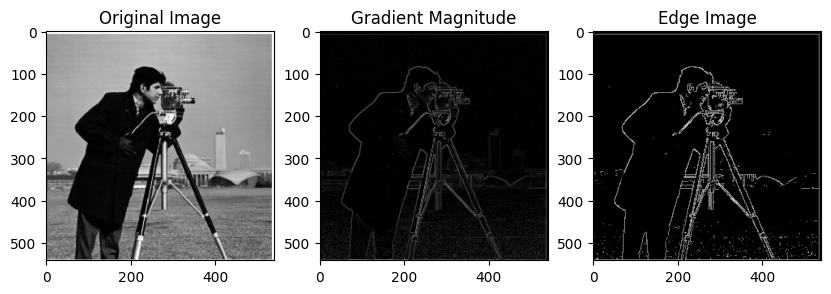

In [2]:
# Part 1.1
# Load grayscale image
image = cv2.imread('cameraman.png', cv2.IMREAD_GRAYSCALE)

# Finite difference filters
D_x = np.array([[-1, 1]])
D_y = np.array([[-1], [1]])

# Convolve
I_x = convolve2d(image, D_x, mode='same', boundary='symm')
I_y = convolve2d(image, D_y, mode='same', boundary='symm')

# Compute the gradient magnitude
gradient_magnitude = np.sqrt(I_x**2 + I_y**2)

# Output edge image using set threshold
threshold = 50
edge_image = (gradient_magnitude > threshold).astype(np.uint8)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Gradient Magnitude')
plt.imshow(gradient_magnitude, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Edge Image')
plt.imshow(edge_image, cmap='gray')

plt.show()

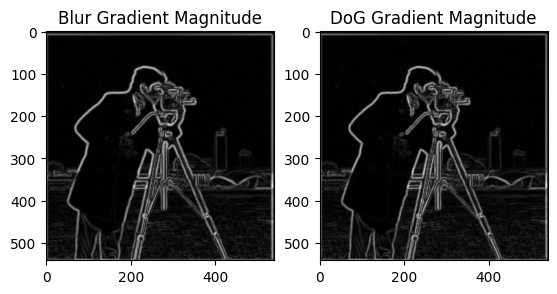

In [3]:
# Part 1.2
# Create 2D Gaussian filter
sigma = 2
size = 10
gaussian_1d = cv2.getGaussianKernel(size, sigma)
gaussian_2d = gaussian_1d @ gaussian_1d.T

# Blur the image using Gaussian filter
blur_image = convolve2d(image, gaussian_2d, mode='same', boundary='symm')

# Compute gradient mangnitude for blurred image
blur_I_x = convolve2d(blur_image, D_x, mode='same', boundary='symm')
blur_I_y = convolve2d(blur_image, D_y, mode='same', boundary='symm')
blur_gradient_magnitude = np.sqrt(blur_I_x**2 + blur_I_y**2)

# Create DoG filters
DoG_x = convolve2d(gaussian_2d, D_x, mode='same', boundary='symm')
DoG_y = convolve2d(gaussian_2d, D_y, mode='same', boundary='symm')

# Step 5: Apply DoG filters to the original image
dog_I_x = convolve2d(image, DoG_x, mode='same', boundary='symm')
dog_I_y = convolve2d(image, DoG_y, mode='same', boundary='symm')
dog_gradient_magnitude = np.sqrt(dog_I_x**2 + dog_I_y**2)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Blur Gradient Magnitude')
plt.imshow(blur_gradient_magnitude, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('DoG Gradient Magnitude')
plt.imshow(dog_gradient_magnitude, cmap='gray')

plt.show()

In [4]:
def sharpen_image(image_path, name, alpha=1, sigma=2, size=5):
    # Load the image in RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create the identity filter
    identity = np.zeros((size, size))
    identity[size // 2, size // 2] = 1

    # Create the 2D Gaussian filter
    gaussian_1d = cv2.getGaussianKernel(size, sigma)
    gaussian_2d = gaussian_1d @ gaussian_1d.T

    # Create the combined sharpening kernel
    sharpening_kernel = (1 + alpha) * identity - alpha * gaussian_2d

    # Split the RGB channels
    r_channel, g_channel, b_channel = cv2.split(image_rgb)

    # Apply the sharpening kernel to each channel
    sharpened_r = convolve2d(r_channel, sharpening_kernel, mode='same', boundary='symm')
    sharpened_g = convolve2d(g_channel, sharpening_kernel, mode='same', boundary='symm')
    sharpened_b = convolve2d(b_channel, sharpening_kernel, mode='same', boundary='symm')

    # Clip values
    sharpened_r = np.clip(sharpened_r, 0, 255).astype(np.uint8)
    sharpened_g = np.clip(sharpened_g, 0, 255).astype(np.uint8)
    sharpened_b = np.clip(sharpened_b, 0, 255).astype(np.uint8)

    # Merge the channels
    sharpened_image_rgb = cv2.merge([sharpened_r, sharpened_g, sharpened_b])

    # Display the original and sharpened images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Original {name}')
    plt.imshow(image_rgb)

    plt.subplot(1, 2, 2)
    plt.title('Sharpened {name}')
    plt.imshow(sharpened_image_rgb)

    plt.show()

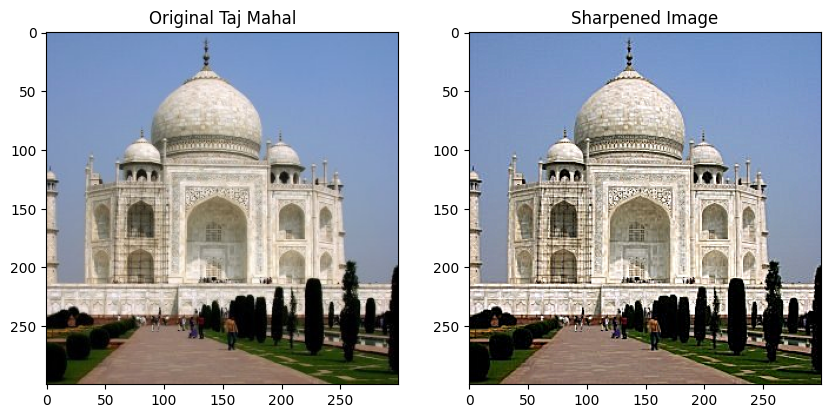

In [6]:
sharpen_image('taj.jpg', 'Taj Mahal')

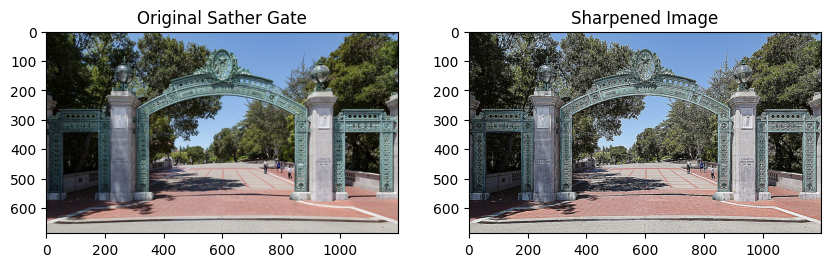

In [8]:
sharpen_image('sather_gate.jpg', 'Sather Gate', alpha=3, sigma=10)

In [5]:
def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape

    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, (dscale, dscale, 1)) # should be same as passing multichannel=True
    else:
        im2 = sktr.rescale(im2, (1./dscale, 1./dscale, 1))
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

In [19]:
# Helper functions of filters
def low_pass_filter(image, sigma):
    size = int(2 * (np.ceil(3 * sigma)) + 1)
    return cv2.GaussianBlur(image, (size, size), sigma)

def high_pass_filter(image, sigma):
    low_frequencies = low_pass_filter(image, sigma)
    return image - low_frequencies

def create_hybrid_image(image1, image2, sigma):
    low_frequencies = high_pass_filter(image1, sigma)
    high_frequencies = low_pass_filter(image2, sigma)
    hybrid_image = np.clip((low_frequencies + high_frequencies)/2.0, 0, 1)
    return low_frequencies, high_frequencies, hybrid_image

def create_and_plot_hybrid_image(image_path1, image_path2, sigma, frequency_analysis=False):
    # Load the images in color
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    # Convert images to floats
    image1 = image1.astype(np.float32) / 255.0
    image2 = image2.astype(np.float32) / 255.0

    # Align the imagess
    %matplotlib qt
    aligned_image1, aligned_image2 = align_images(image1, image2)
    %matplotlib inline

    # Convert to grayscale
    aligned_image1_gray = cv2.cvtColor((aligned_image1 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    aligned_image2_gray = cv2.cvtColor((aligned_image2 * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

    # Hybrid image
    low_frequencies, high_frequencies, hybrid_img = create_hybrid_image(aligned_image1_gray, aligned_image2_gray, sigma)

    # Display
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image 1')
    plt.imshow(aligned_image1_gray, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Image 2')
    plt.imshow(aligned_image2_gray, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Hybrid Image')
    plt.imshow(hybrid_img, cmap='gray')
    plt.show()

    # Frequency analysis
    if frequency_analysis:
        def plot_frequency_analysis(image, title, subplot_index):
            frequency_transform = np.fft.fftshift(np.fft.fft2(image))
            log_magnitude = np.log(np.abs(frequency_transform))
            plt.subplot(2, 3, subplot_index)
            plt.title(title)
            plt.imshow(log_magnitude, cmap='gray')

        plt.figure(figsize=(18, 10))

        plot_frequency_analysis(aligned_image1_gray, 'Frequency - Image 1', 1)
        plot_frequency_analysis(aligned_image2_gray, 'Frequency - Image 2', 2)

        plot_frequency_analysis(low_frequencies, 'Frequency - High Pass Filtered Image 1', 3)
        plot_frequency_analysis(high_frequencies, 'Frequency - Low Pass Filtered Image 2', 4)

        plot_frequency_analysis(hybrid_img, 'Frequency - Hybrid Image', 5)

        plt.tight_layout()
        plt.show()

QEventDispatcherMac::unregisterSocketNotifier: Tried to unregister a not registered notifier


Please select 2 points in each image for alignment.


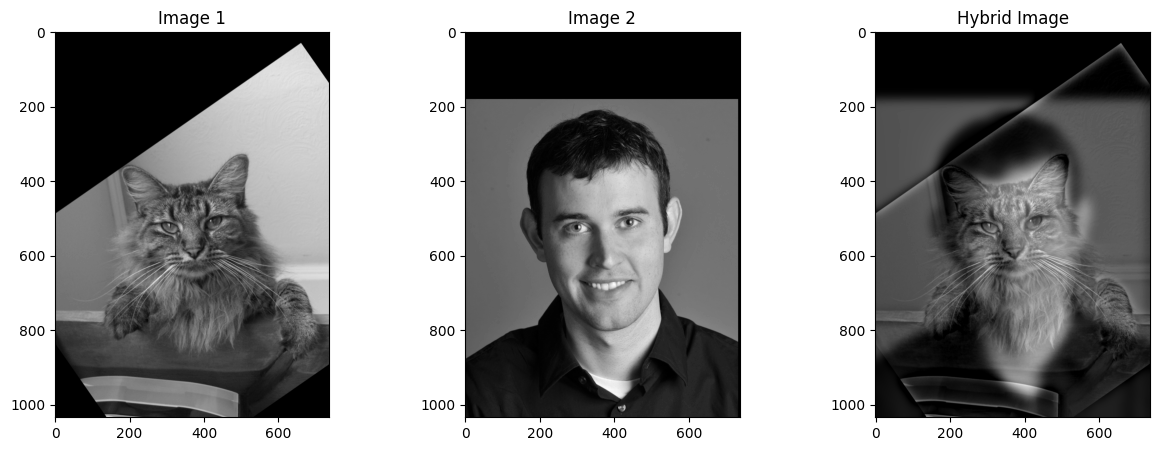

In [21]:
create_and_plot_hybrid_image('nutmeg.jpg', 'DerekPicture.jpg', sigma=13)

Please select 2 points in each image for alignment.


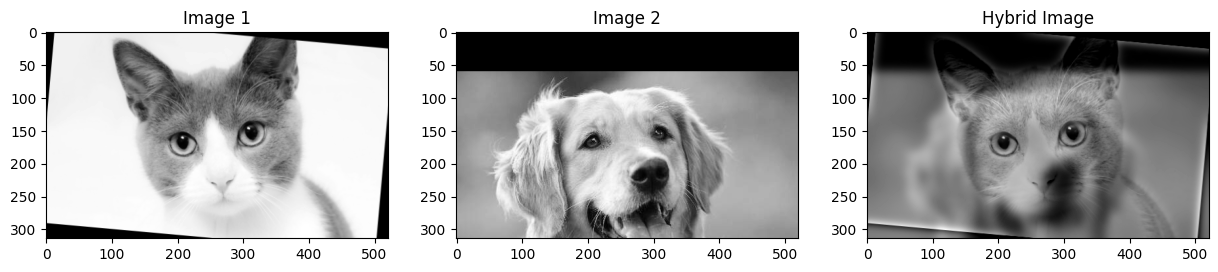

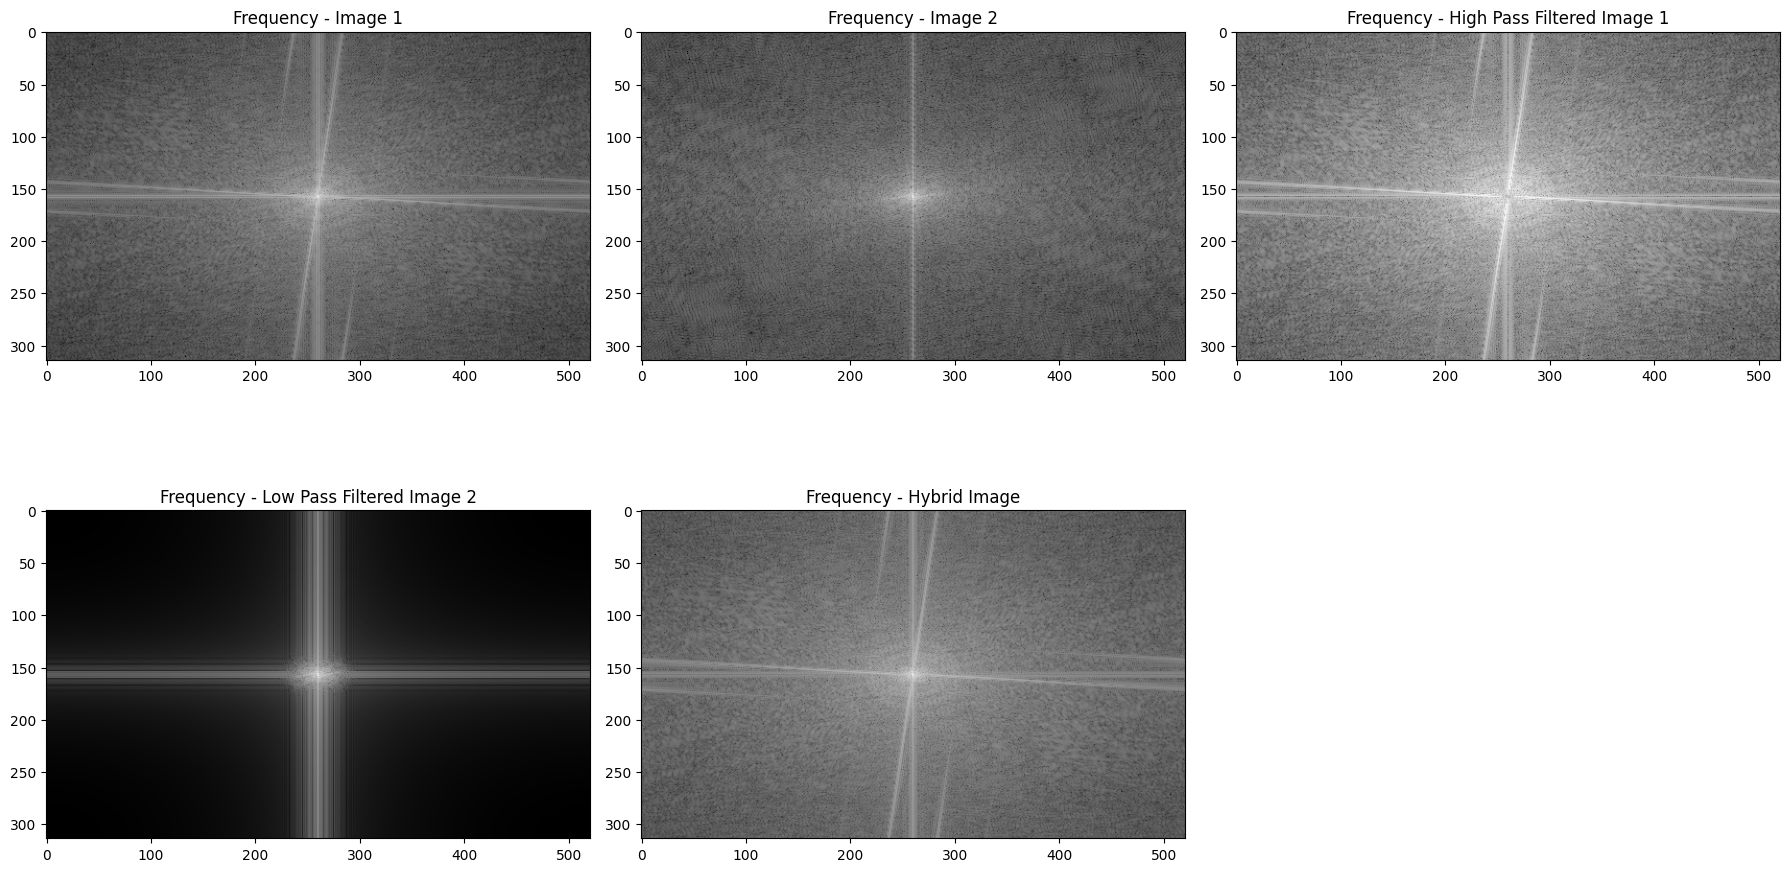

In [36]:
create_and_plot_hybrid_image('cat.jpg', 'dog.jpg', sigma=7, frequency_analysis=True)

Please select 2 points in each image for alignment.


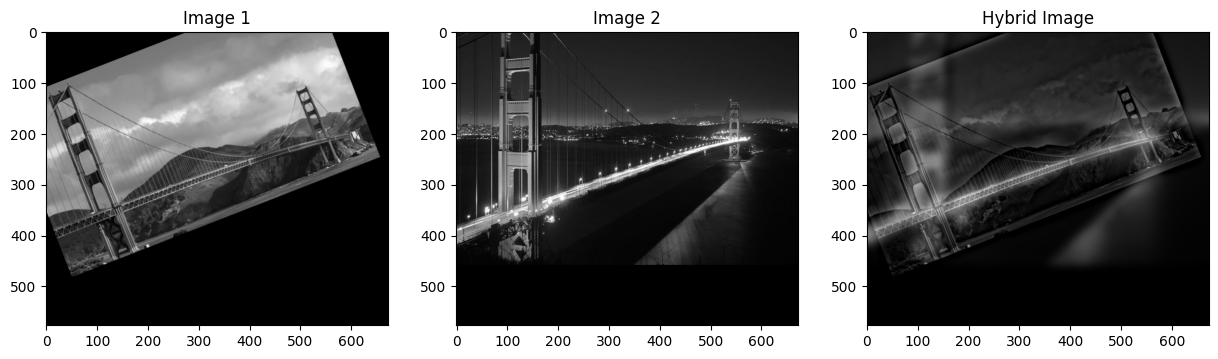

In [25]:
create_and_plot_hybrid_image('day_bridge.jpg', 'night_bridge.jpg', sigma=8)

In [6]:
# Helper functions to create Gaussian and Laplacian stacks
def gaussian_stack(image, levels, sigma=1):
    gaussian_stack = [image]
    for i in range(1, levels):
        blurred_image = cv2.GaussianBlur(gaussian_stack[-1], (0, 0), sigma)
        gaussian_stack.append(blurred_image)
    return gaussian_stack

def laplacian_stack(gaussian_stack):
    laplacian_stack = []
    for i in range(len(gaussian_stack) - 1):
        laplacian = gaussian_stack[i] - gaussian_stack[i + 1]
        laplacian_stack.append(laplacian)
    laplacian_stack.append(gaussian_stack[-1])
    return laplacian_stack

#Upsample using resize
def upsample(image, target_shape):
    return cv2.resize(image, target_shape, interpolation=cv2.INTER_LINEAR)

def blend(image1, image2, levels=8, sigma=5):
    # Dimension check
    height, width = min(image1.shape[0], image2.shape[0]), min(image1.shape[1], image2.shape[1])
    image1 = cv2.resize(image1, (width, height))
    image2 = cv2.resize(image2, (width, height))

    # Step 1a in paper
    image1_gaussian_stack = gaussian_stack(image1, levels, sigma)
    image2_gaussian_stack = gaussian_stack(image2, levels, sigma)
    image1_laplacian_stack = laplacian_stack(image1_gaussian_stack)
    image2_laplacian_stack = laplacian_stack(image2_gaussian_stack)

    # Step 1b
    left_half = np.ones((height, width // 2), dtype=np.float32)
    right_half = np.zeros((height, width - width // 2), dtype=np.float32)
    mask = np.concatenate((left_half, right_half), axis=1)

    # Create Gaussian stack for the mask
    mask_gaussian_stack = gaussian_stack(mask, levels, sigma)

    # Step 2
    blended_laplacian_stack = []
    for i in range(levels):
        mask_level = mask_gaussian_stack[i][:, :, None]
        blended = mask_level * image1_laplacian_stack[i] + (1 - mask_level) * image2_laplacian_stack[i]
        blended_laplacian_stack.append(blended)

    # Step 3
    blended_image = blended_laplacian_stack[-1]
    for i in range(levels - 2, -1, -1):
        target_shape = (blended_laplacian_stack[i].shape[1], blended_laplacian_stack[i].shape[0])  # Width, Height
        blended_image = upsample(blended_image, target_shape)  # Upsample to the next level
        blended_image += blended_laplacian_stack[i]

    # Clip values
    blended_image = np.clip(blended_image, 0, 1)
    
    return blended_image

In [7]:
def blend_and_display(image1_path, image2_path, sigma, name1, name2, levels=8):
    # Load the images
    image1 = cv2.imread(image1_path).astype(np.float32) / 255.0
    image2 = cv2.imread(image2_path).astype(np.float32) / 255.0

    # Blend the two images using the blend function
    blended_image = blend(image1, image2, levels=levels, sigma=sigma)

    # Display the results
    plt.figure(figsize=(18, 6))

    # Display the original images
    plt.subplot(1, 3, 1)
    plt.title(name1)
    plt.imshow(cv2.cvtColor((image1 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(name2)
    plt.imshow(cv2.cvtColor((image2 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Display the blended image
    plt.subplot(1, 3, 3)
    plt.title(f'Blended Image ({name1} + {name2})')
    plt.imshow(cv2.cvtColor((blended_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

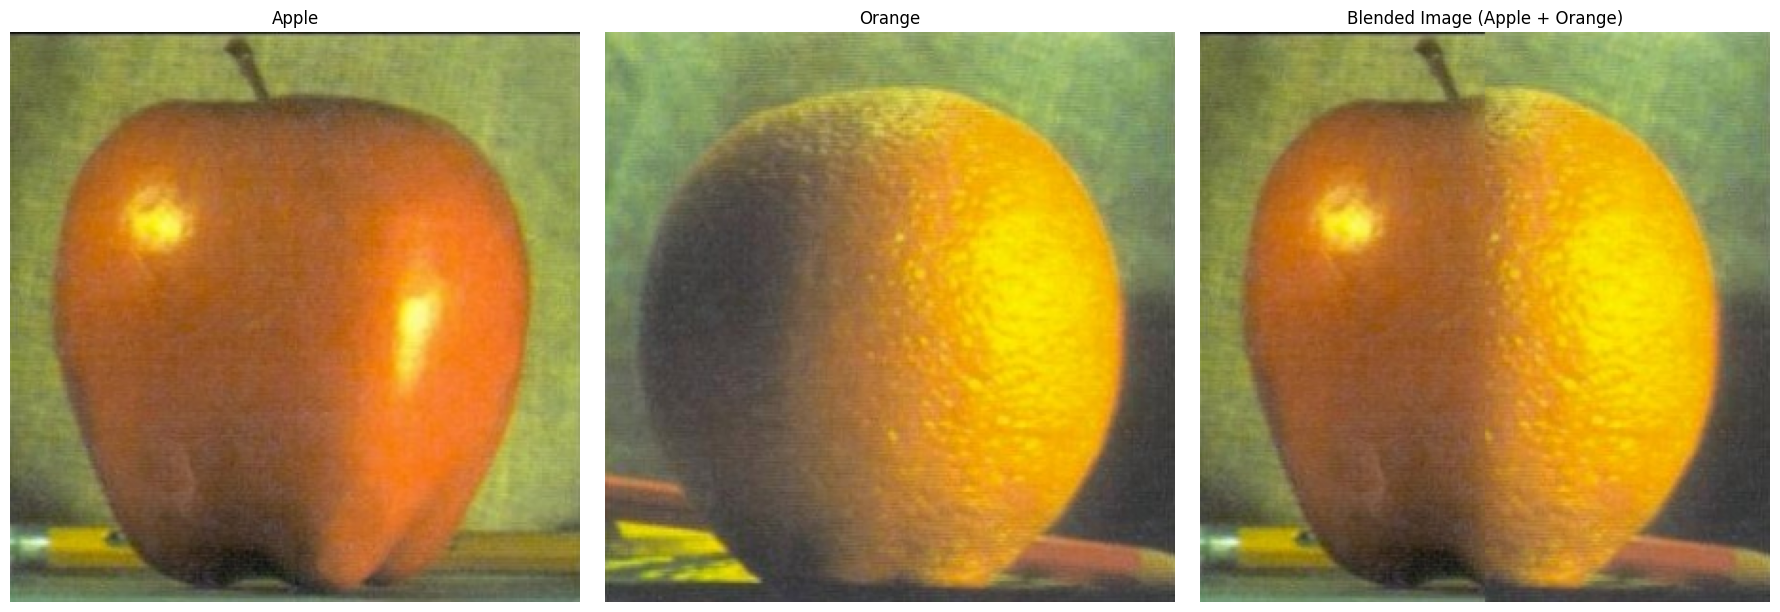

In [8]:
blend_and_display('apple.jpeg', 'orange.jpeg', sigma=5, name1='Apple', name2='Orange')

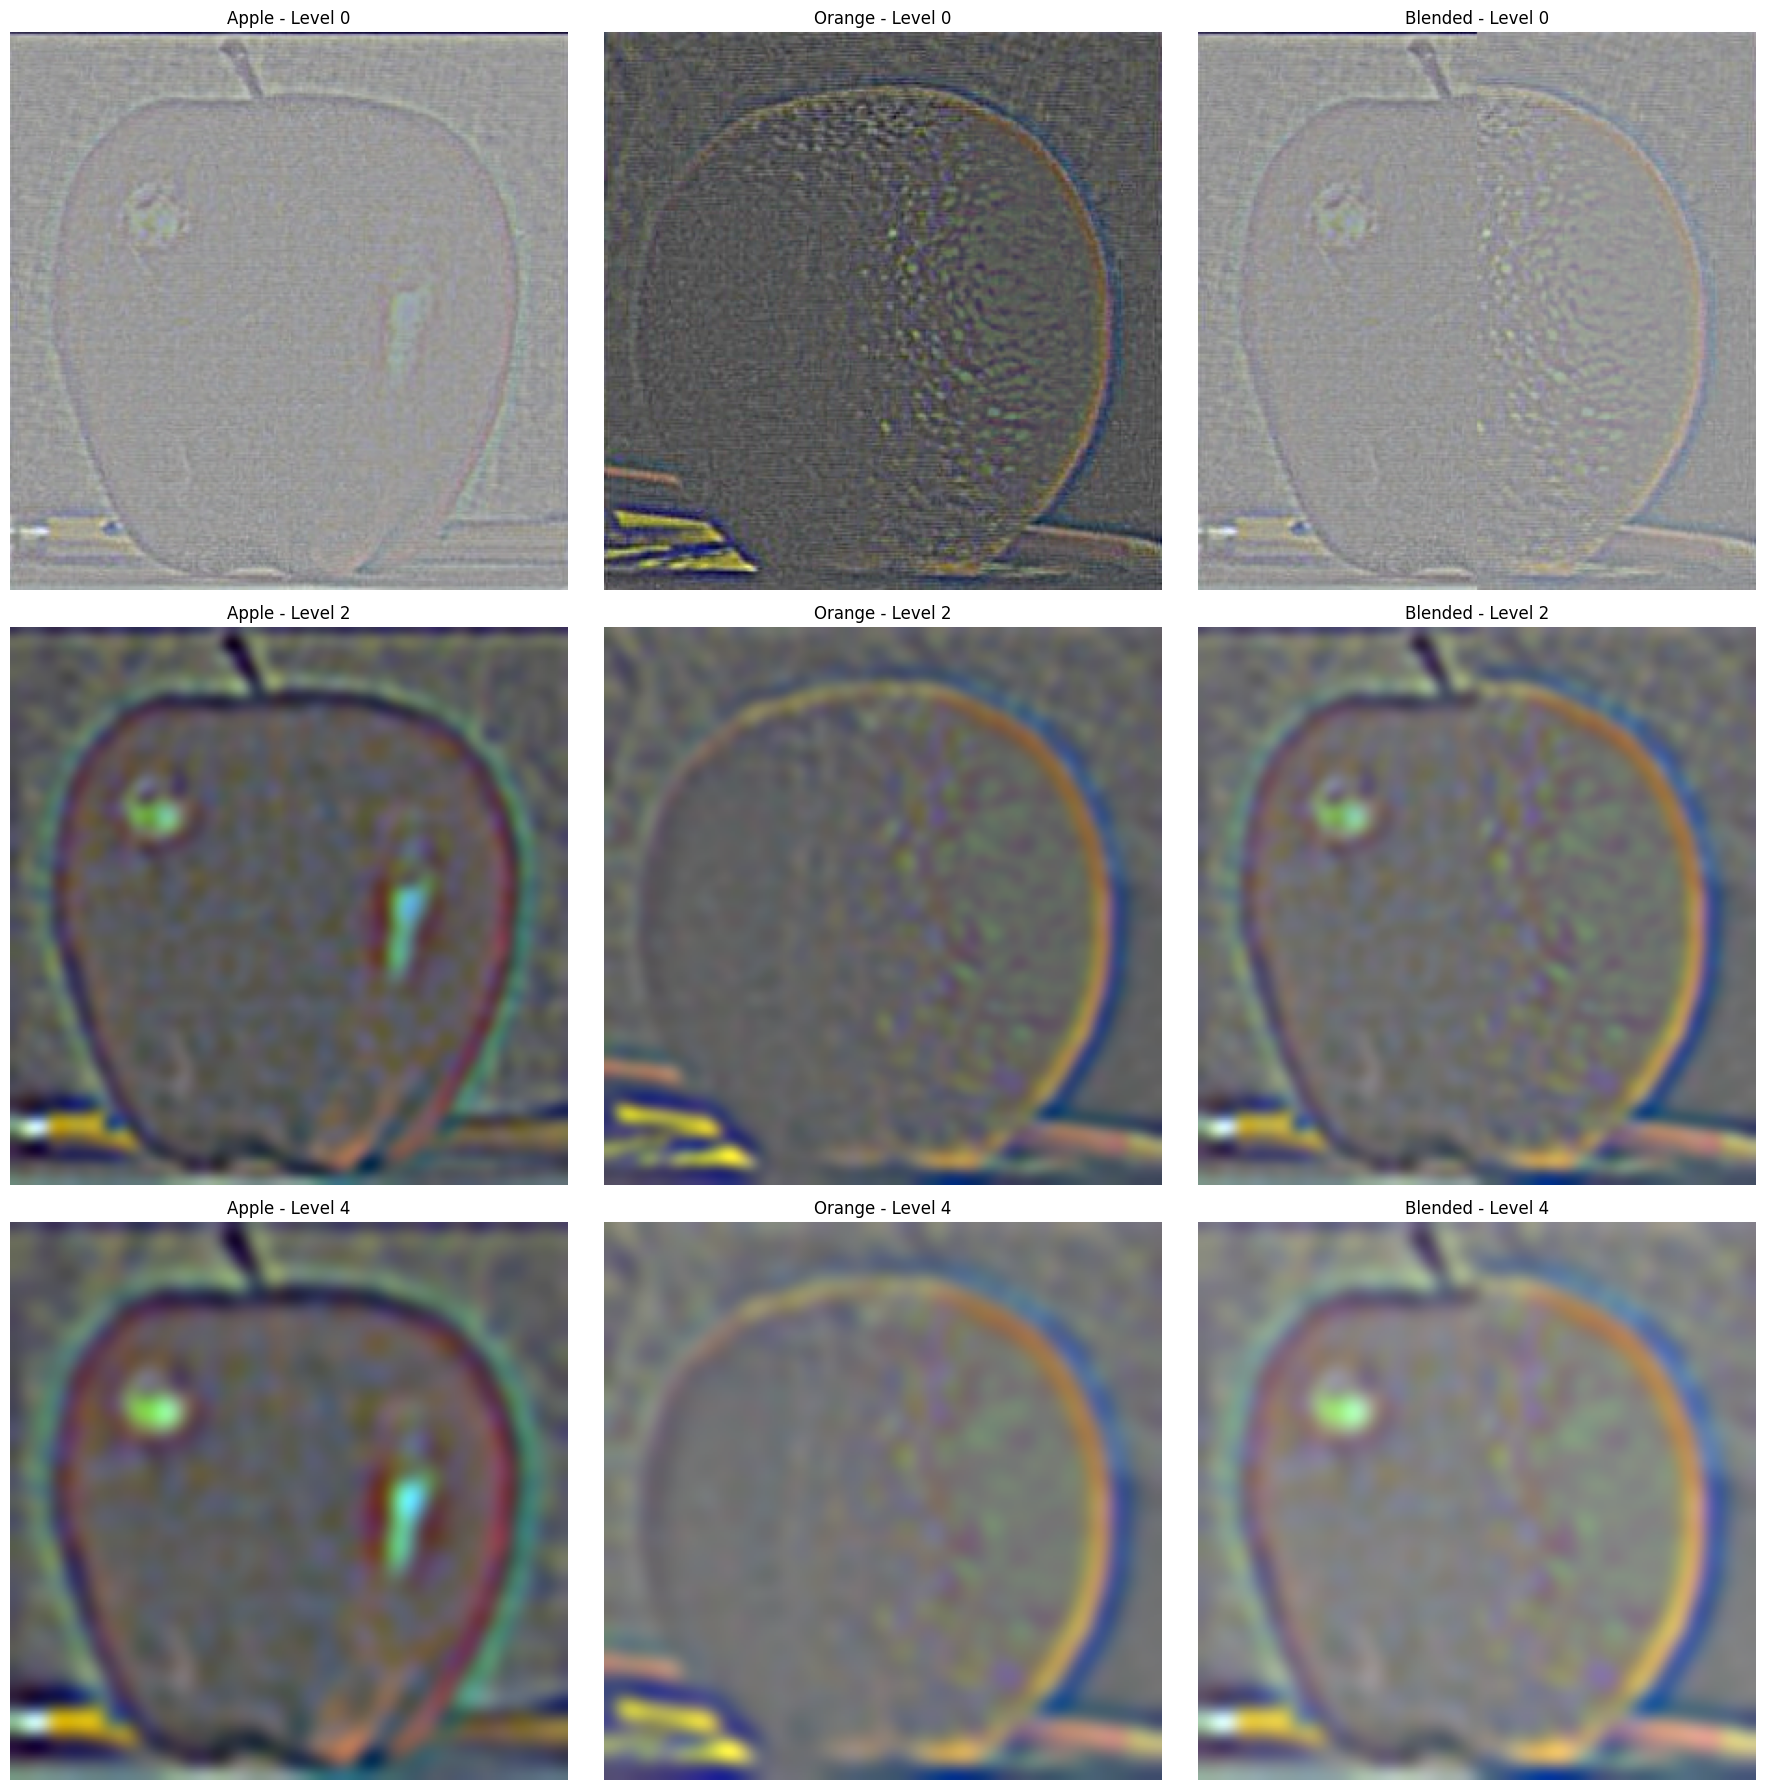

In [10]:
#2.3 Display laplacian stack
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Blend function modified to return Laplacian stacks
def blend_and_display_stack(image1_path, image2_path, sigma, name1, name2, levels=8):
    image1 = cv2.imread(image1_path).astype(np.float32) / 255.0
    image2 = cv2.imread(image2_path).astype(np.float32) / 255.0

    height, width = min(image1.shape[0], image2.shape[0]), min(image1.shape[1], image2.shape[1])
    image1 = cv2.resize(image1, (width, height))
    image2 = cv2.resize(image2, (width, height))

    image1_gaussian_stack = gaussian_stack(image1, levels, sigma)
    image2_gaussian_stack = gaussian_stack(image2, levels, sigma)
    image1_laplacian_stack = laplacian_stack(image1_gaussian_stack)
    image2_laplacian_stack = laplacian_stack(image2_gaussian_stack)

    left_half = np.ones((height, width // 2), dtype=np.float32)
    right_half = np.zeros((height, width - width // 2), dtype=np.float32)
    mask = np.concatenate((left_half, right_half), axis=1)

    mask_gaussian_stack = gaussian_stack(mask, levels, sigma)

    blended_laplacian_stack = []
    for i in range(levels):
        mask_level = mask_gaussian_stack[i][:, :, None]
        blended = mask_level * image1_laplacian_stack[i] + (1 - mask_level) * image2_laplacian_stack[i]
        blended_laplacian_stack.append(blended)

    levels_to_display = [0, 2, 4]
    plt.figure(figsize=(18, len(levels_to_display) * 6))

    for idx, level in enumerate(levels_to_display):
        normalized_image1 = normalize_image(image1_laplacian_stack[level])
        normalized_image2 = normalize_image(image2_laplacian_stack[level])
        normalized_blended = normalize_image(blended_laplacian_stack[level])

        plt.subplot(len(levels_to_display), 3, 3 * idx + 1)
        plt.title(f'Apple - Level {level}')
        plt.imshow(cv2.cvtColor((normalized_image1 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(len(levels_to_display), 3, 3 * idx + 2)
        plt.title(f'Orange - Level {level}')
        plt.imshow(cv2.cvtColor((normalized_image2 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(len(levels_to_display), 3, 3 * idx + 3)
        plt.title(f'Blended - Level {level}')
        plt.imshow(cv2.cvtColor((normalized_blended * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

blend_and_display_stack('apple.jpeg', 'orange.jpeg', sigma=3, name1='Apple', name2='Orange')